# Credit Card Fraud Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import itertools
import pickle
import warnings
warnings.filterwarnings("ignore")

Dataset Link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [2]:
# Loading data
df_original = pd.read_csv(r'C:\Users\fakhi\Downloads\Web App\creditcard.csv')
df_original.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Creating a copy of original dataframe to later apply different transformations
# So we dont have to import it again
df = df_original.copy()

In [4]:
# Checking the shape of data
print(f"This data has {df.shape[0]} rows and {df.shape[1]} columns.")

This data has 284807 rows and 31 columns.


In [5]:
# Checking data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Checking for null values
df.isnull().sum().sum()

0

In [7]:
# Checking for duplicate data
df.duplicated().sum()

1081

In [8]:
# Removing duplicate data
df = df[~df.duplicated()]

In [9]:
# Statistical Summary of data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


#### Dataset Statistical Summary:

The provided summary offers a comprehensive view of the key statistics within our fraud detection dataset. Below is a breakdown of the important information derived from this summary table:

#### Data Completeness:

All columns have 283,726 records, indicating a complete dataset without any missing values.

#### Temporal Information (Time):

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
The average time for that is 94,811.08 seconds.
The earliest transaction occurred at time 0 seconds, and the latest at 172,792 seconds.

#### Transaction Amounts:

The average transaction amount is 88.47, with a standard deviation of 250.40, signifying a notable spread in transaction values.

The minimum transaction amount is 0.00, and the maximum reaches 25,691.16.

#### Feature Characteristics (V1 to V28):

Due to confidentiality issues, there is no information provided regarding the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.

#### Fraud Class Distribution:

The 'Class' column represents the fraud status (1 for fraudulent, 0 for non-fraudulent).

#### Percentiles (25%, 50%, 75%):

The 25th percentile of transaction amounts is 5.60, providing insight into the lower end of the transaction value distribution.
The median (50th percentile) amount is 22.00, giving a central tendency measure.
The 75th percentile value of 77.51 indicates the transaction amount below which 75%  of the data falls

#### Outliers:

Maximum values for features and amounts are significantly higher than the 75th percentiles, indicating the presence of potential outliers.

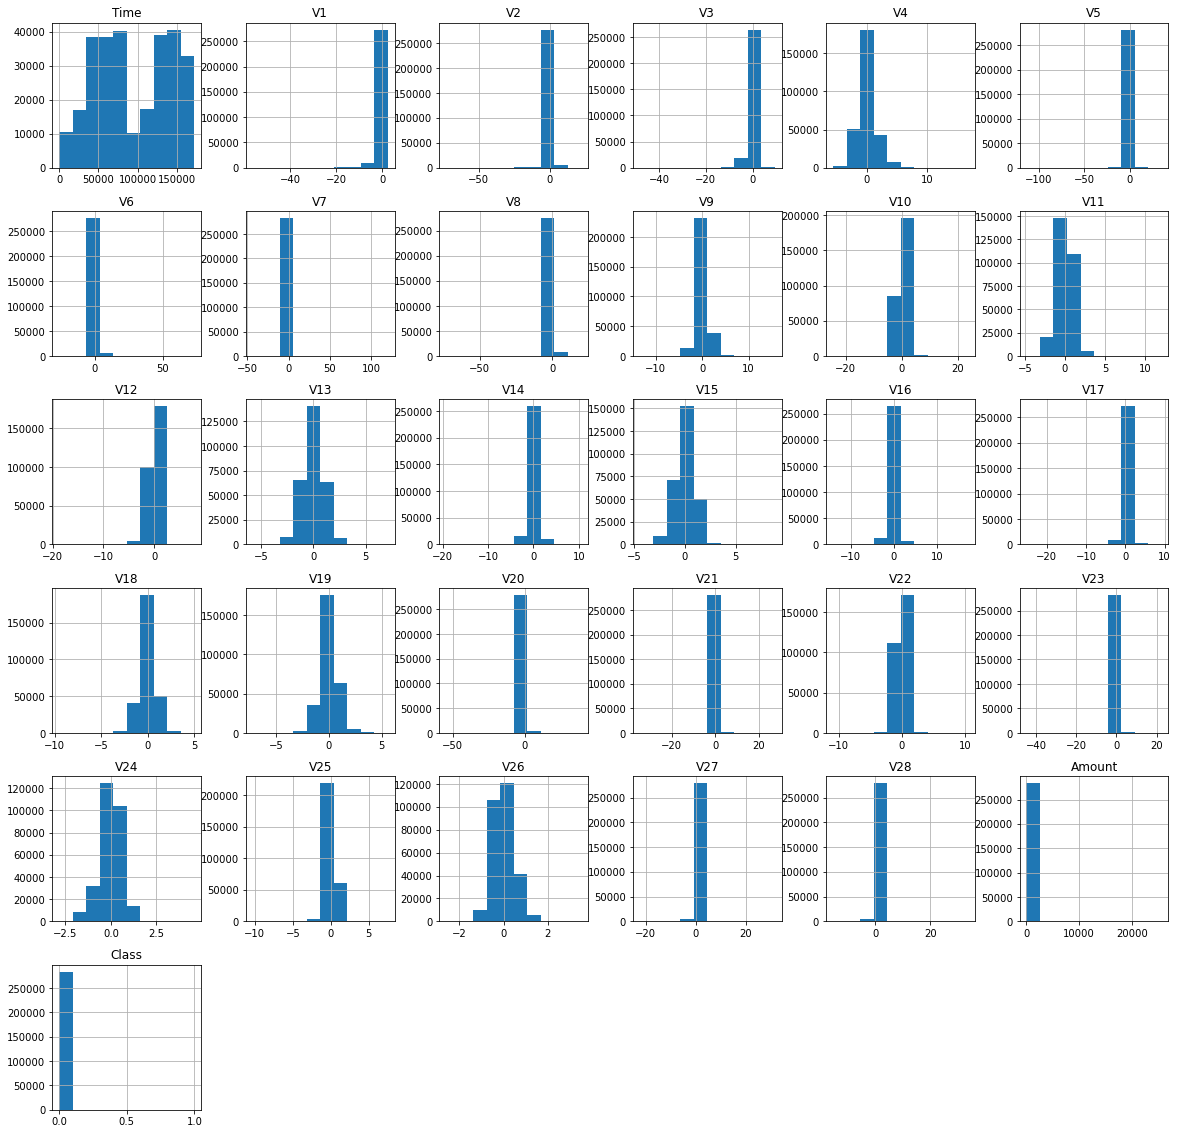

In [10]:
# Checking distribution of all features
df.hist(figsize=(20,20));

Text(0.5, 1.0, 'Time Vs Class')

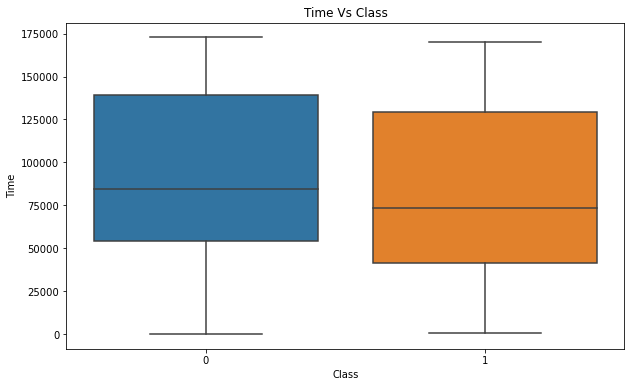

In [11]:
# Relationship between Time and Fraudulent/Non-Fraudulent Transactions
plt.figure(figsize=(10,6))
sns.boxplot(x='Class', y ='Time', data=df)
plt.title("Time Vs Class")

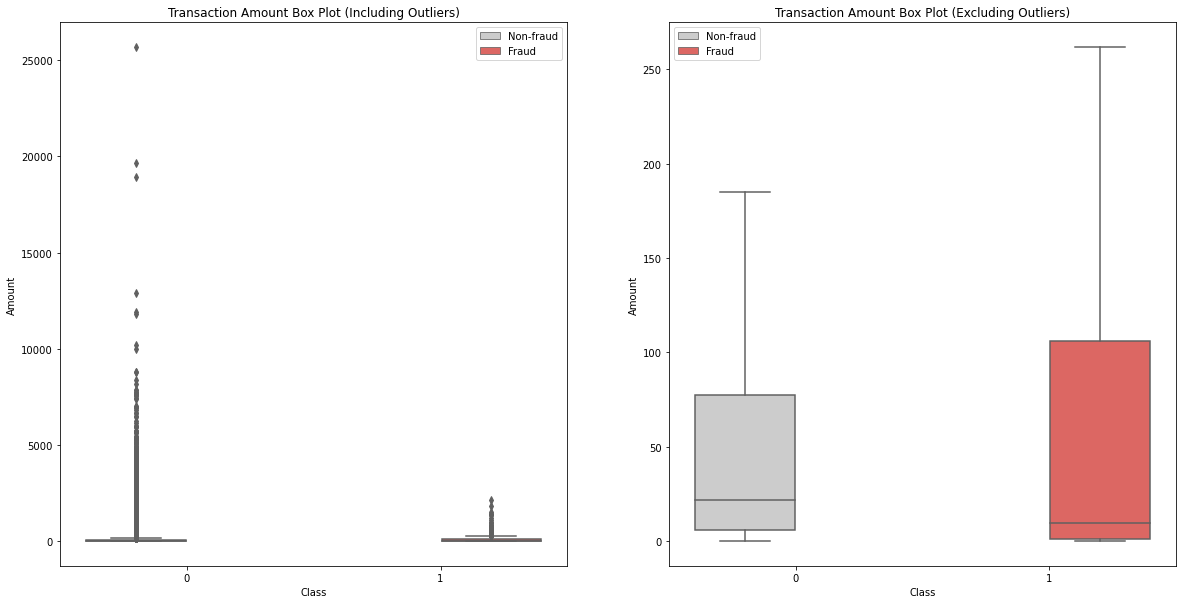

In [12]:
# Custom colors for our data

gray_color = "#CCCCCC" # Grey for regular txs
red_color = "#F0544F" # Red for fraudulent txs

color_pal = [gray_color, red_color]

fig, ax = plt.subplots(ncols=2, figsize=(20,10))

sns.boxplot(data=df, 
            x="Class", 
            y="Amount", 
            hue="Class",
            palette=color_pal,
            showfliers=True,
            ax=ax[0])

sns.boxplot(data=df, 
            x="Class", 
            y="Amount", 
            hue="Class",
            palette=color_pal,
            showfliers=False,
            ax=ax[1])

# Add titles to the plots
ax[0].set_title("Transaction Amount Box Plot (Including Outliers)")
ax[1].set_title("Transaction Amount Box Plot (Excluding Outliers)")

# Update legend labels
legend_labels = ['Non-fraud', 'Fraud']
for i in range(2):
    handles, _ = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, legend_labels)


plt.show()

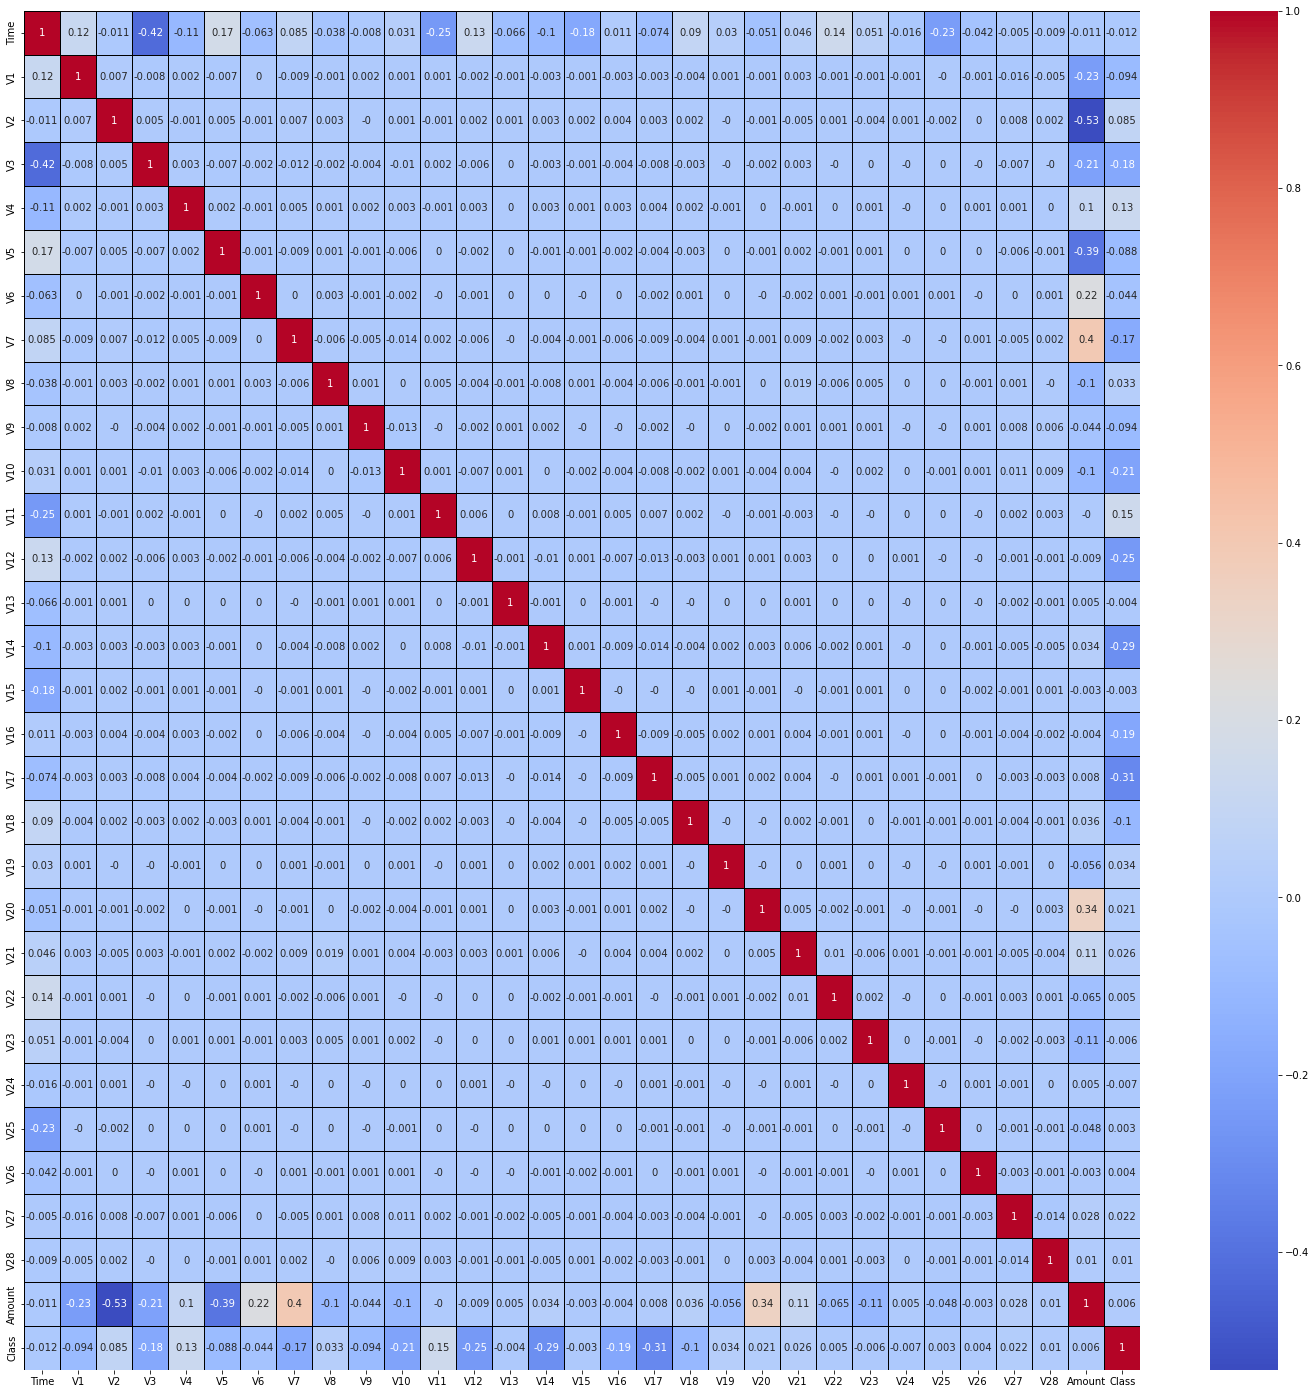

In [13]:
# correlation between all numerical features 
plt.figure(figsize=(25,25))
sns.heatmap(round(df.corr(),3),annot = True,cmap = 'coolwarm',
            linewidths = 0.5 ,linecolor='black')# plotting correlation heatmap
plt.show()

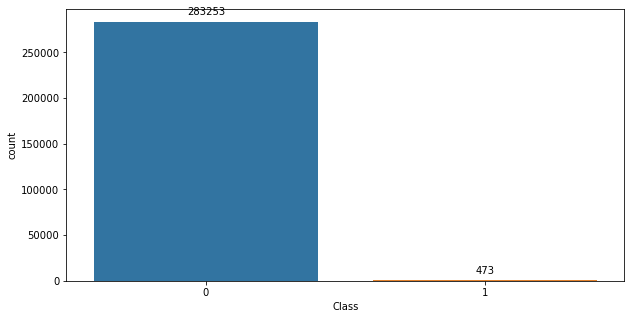

In [14]:
# Checking class distribution
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Class', data=df)

# Add counts (integers) on top of each bar
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

As we can see, the class distribution is highly imbalanced, i.e., fraudulent cases are much less than the non-fraudulent ones, which can lead to "bias" in our models.

In [15]:
# Separating X and y
X = df.drop('Class', axis=1)
y = df['Class']

## Creating Models on Imbalanced Data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

In [17]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (198608, 30)
y_train shape: (198608,)
X_test shape: (85118, 30)
y_test shape: (85118,)


In [18]:
# Data Scaling
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic Regression

In [19]:
lr = LogisticRegression()

lr.fit(X_train_scaled, y_train)

LogisticRegression()

In [20]:
lr_pred = lr.predict(X_test_scaled)

print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.84      0.56      0.67       142

    accuracy                           1.00     85118
   macro avg       0.92      0.78      0.83     85118
weighted avg       1.00      1.00      1.00     85118



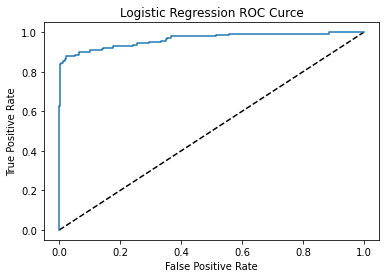

In [21]:
lr_pred_prob = lr.predict_proba(X_test_scaled)[:,1]
roc_auc_score(y_test, lr_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, lr_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curce')
plt.show();

#### XGBoost

In [22]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
xgb_pred = xgb.predict(X_test)

print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.75      0.84       142

    accuracy                           1.00     85118
   macro avg       0.98      0.87      0.92     85118
weighted avg       1.00      1.00      1.00     85118



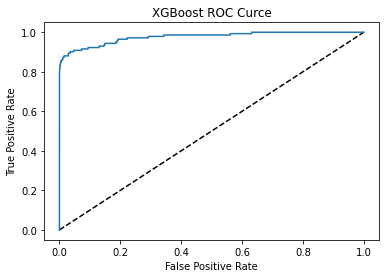

In [24]:
xgb_pred_prob = xgb.predict_proba(X_test)[:,1]
roc_auc_score(y_test, xgb_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, xgb_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curce')
plt.show();

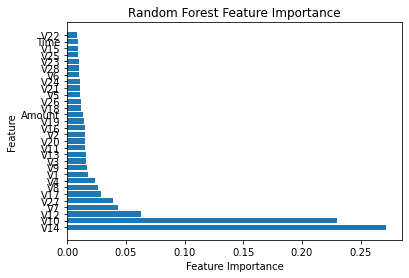

In [25]:
feature_importance = xgb.feature_importances_
feature_names = X_train.columns

feature_importance_dict = dict(zip(feature_names, feature_importance))

sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# for feature, importance in sorted_feature_importance:
#     print(f"{feature}: {importance}")

plt.barh(*zip(*sorted_feature_importance))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

In [26]:
sorted_feature_importance

[('V14', 0.27173212),
 ('V10', 0.22941865),
 ('V12', 0.062473226),
 ('V7', 0.043291297),
 ('V27', 0.038511533),
 ('V17', 0.02886707),
 ('V8', 0.026049191),
 ('V4', 0.02349235),
 ('V1', 0.01788999),
 ('V9', 0.01678246),
 ('V3', 0.016067613),
 ('V13', 0.015533447),
 ('V11', 0.015303093),
 ('V20', 0.015025221),
 ('V2', 0.014859331),
 ('V16', 0.014839425),
 ('V19', 0.014050902),
 ('Amount', 0.013509481),
 ('V18', 0.012000661),
 ('V26', 0.011952406),
 ('V5', 0.011114858),
 ('V21', 0.011023186),
 ('V24', 0.01090159),
 ('V6', 0.010199813),
 ('V28', 0.009718535),
 ('V23', 0.009675218),
 ('V25', 0.009256206),
 ('V15', 0.009055204),
 ('Time', 0.009041268),
 ('V22', 0.008364684)]

In [27]:
selected_features = []

# Loop through the sorted feature importance and store names with importance > 0.30
for feature, importance in sorted_feature_importance:
    if importance < 0.013563101:
        continue
    selected_features.append(feature)

# Now, selected_features contains the names of features with importance > 0.30
print("Selected Features:", selected_features)

Selected Features: ['V14', 'V10', 'V12', 'V7', 'V27', 'V17', 'V8', 'V4', 'V1', 'V9', 'V3', 'V13', 'V11', 'V20', 'V2', 'V16', 'V19']


#### Random Forest Classifier

In [28]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [29]:
rfc_pred = rfc.predict(X_test)

print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.95      0.75      0.84       142

    accuracy                           1.00     85118
   macro avg       0.98      0.87      0.92     85118
weighted avg       1.00      1.00      1.00     85118



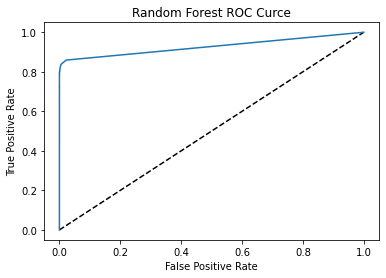

In [30]:
rfc_pred_prob = rfc.predict_proba(X_test)[:,1]
roc_auc_score(y_test, rfc_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, rfc_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RFC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curce')
plt.show();

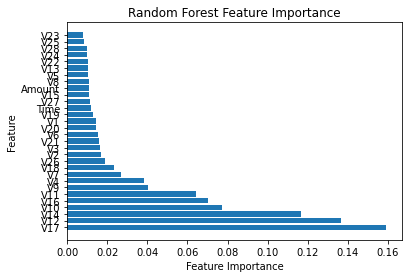

In [31]:
# Get feature importance
feature_importance_rfc = rfc.feature_importances_
feature_names = X_train.columns 

feature_importance_dict = dict(zip(feature_names, feature_importance_rfc))
sorted_feature_importance_rfc = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# for feature, importance in sorted_feature_importance_rfc:
#     print(f"{feature}: {importance}")

# Plot feature importance
plt.barh(*zip(*sorted_feature_importance_rfc))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()

## Balancing the data by doing Undersampling

In [32]:
# !pip install -U threadpoolctl

In [33]:
class_0_samples = df[df['Class'] == 0].sample(n=1500, random_state=42)
class_1_samples = df[df['Class'] == 1]

df_sm = pd.concat([class_0_samples, class_1_samples], ignore_index=True)

df_us = pd.concat([class_0_samples, class_1_samples])
df_us = df_sm.sample(frac=1, random_state=42).reset_index(drop=True)

In [34]:
df_us.shape

(1973, 31)

In [35]:
selected_features.append('Class')

In [36]:
df_us = df_us[selected_features]

In [37]:
X_us= df_us.drop(columns=['Class'])
y_us = df_us['Class']

In [38]:
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, stratify = y_us, test_size=0.25, random_state=42)

In [39]:
df_us['Class'].value_counts()

0    1500
1     473
Name: Class, dtype: int64

In [40]:
scaler_us = StandardScaler()

scaler_us.fit(X_train_us)

X_train_us_sc = scaler_us.transform(X_train_us)
X_test_us_sc = scaler_us.transform(X_test_us)

## Creating Models with Balanced data

#### Logistic Regression

In [41]:
lr2 = LogisticRegression()

lr2.fit(X_train_us_sc, y_train_us)

LogisticRegression()

In [42]:
lr2_pred = lr2.predict(X_test_us_sc)

print(classification_report(y_test_us, lr2_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       376
           1       0.96      0.87      0.92       118

    accuracy                           0.96       494
   macro avg       0.96      0.93      0.95       494
weighted avg       0.96      0.96      0.96       494



#### XGBoost

In [43]:
xgb2 = XGBClassifier()

xgb2.fit(X_train_us, y_train_us)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [44]:
xgb2_pred = xgb2.predict(X_test_us)

print(classification_report(y_test_us, xgb2_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       376
           1       0.99      0.87      0.93       118

    accuracy                           0.97       494
   macro avg       0.98      0.94      0.95       494
weighted avg       0.97      0.97      0.97       494



#### Random Forest Classifier

In [45]:
rfc2 = RandomForestClassifier()

rfc2.fit(X_train_us, y_train_us)

RandomForestClassifier()

In [46]:
rfc2_pred = rfc2.predict(X_test_us)

print(classification_report(y_test_us, rfc2_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       376
           1       0.99      0.85      0.91       118

    accuracy                           0.96       494
   macro avg       0.97      0.92      0.94       494
weighted avg       0.96      0.96      0.96       494



In [47]:
lr_re = recall_score(y_test, lr_pred)
lr2_re1 = recall_score(y_test_us, lr2_pred)

xgb_re = recall_score(y_test, xgb_pred)
xgb2_re1 = recall_score(y_test_us, xgb2_pred)

rfc_re = recall_score(y_test, rfc_pred)
rfc2_re1 = recall_score(y_test_us, rfc2_pred)

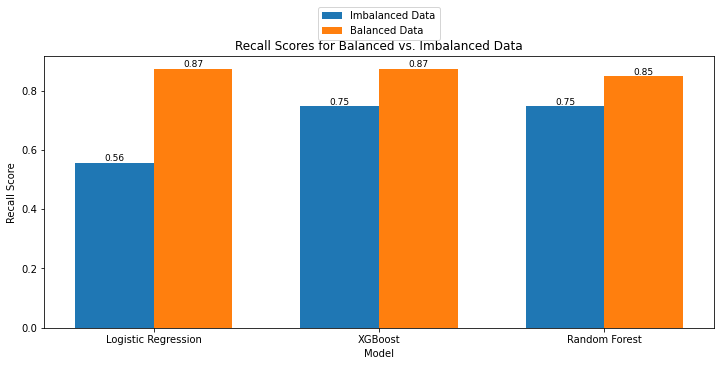

In [48]:
models = ['Logistic Regression', 'XGBoost', 'Random Forest']
recall_scores_imb = [lr_re, xgb_re, rfc_re]  # F1 scores for imbalanced data
recall_scores_bal = [lr2_re1, xgb2_re1, rfc2_re1]  # F1 scores for balanced data

bar_width = 0.35
imb_pos = np.arange(len(models))
bal_pos = imb_pos + bar_width

fig, ax = plt.subplots(figsize=(12,5))
plt.title('Recall Scores for Balanced vs. Imbalanced Data')
plt.xlabel('Model')
plt.ylabel('Recall Score')

imb_bars = ax.bar(imb_pos, recall_scores_imb, width=bar_width, label='Imbalanced Data')
bal_bars = ax.bar(bal_pos, recall_scores_bal, width=bar_width, label='Balanced Data')

# Add annotations on top of each bar
for imb_bar, bal_bar, imb_score, bal_score in zip(imb_bars, bal_bars, recall_scores_imb, recall_scores_bal):
    ax.text(imb_bar.get_x() + imb_bar.get_width() / 2, imb_bar.get_height(),
            f'{imb_score:.2f}', ha='center', va='bottom', fontsize=9, color='black')
    ax.text(bal_bar.get_x() + bal_bar.get_width() / 2, bal_bar.get_height(),
            f'{bal_score:.2f}', ha='center', va='bottom', fontsize=9, color='black')

tick_pos = np.arange(len(models))
ax.set_xticks(tick_pos + bar_width / 2)
ax.set_xticklabels(models)

plt.legend(loc='center', bbox_to_anchor=(0.5, 1.12))

plt.show()


#### Cross validating XGBoost using balanced data

In [49]:
def cross_validation(model, X, y, cv=3, scoring='f1'):
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return cv_scores

In [50]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_recalls = cross_val_score(xgb2, X_us, y_us, cv=kfold, scoring='recall')

In [51]:
recall_mean = xgb_recalls.mean()

In [52]:
# Mean F1-Score from cross validation
print("Cross validation results across 5-Folds:", xgb_recalls)
print("Mean Recall score from cross validation:", recall_mean)

Cross validation results across 5-Folds: [0.90526316 0.91397849 0.85185185 0.83333333 0.87356322]
Mean Recall score from cross validation: 0.8755980112188766


In [53]:
# Define the hyperparameter grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': [100, 200, 300, 400, 500],
}

random_search = RandomizedSearchCV(
    xgb2,
    param_distributions=param_grid,
    scoring='recall',
    cv=5, 
    verbose=1,
    n_jobs=-1,  # Use all available CPUs
    random_state=42,
)

random_search.fit(X_train_us, y_train_us)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42, scoring='recall', verbose=1)

In [54]:
# best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.9}


In [55]:
# Evaluate the model on the test set using the best hyperparameters
xgb_tuned = random_search.best_estimator_
tuned_recall = xgb_tuned.score(X_test_us, y_test_us)
print(f"Recall on Test Set: {tuned_recall:.4f}")

Recall on Test Set: 0.9636


In [56]:
with open('xgb_tuned.pkl', 'wb') as model:
    pickle.dump(xgb_tuned, model)